### Mehdi EL KANSOULI - Assignment RL

In [31]:
import os, sys
import gymnasium as gym
import time
import numpy as np
import matplotlib.pyplot as plt 

# Comment if you're not cloning the whole git. 
# import text_flappy_bird_gym

# from agent import SarsaAgent, MCAgent, SarsaLambdaAgent
# from main import train_mc_agent, train_sarsa_function, inference

# Table of content 


0. General description
1. Algorithms comparison $\newline$
        A. Overall performance $\newline$
        B. Convergence speed $\newline$
        C. Value function of greedy agent $\newline$
2. Sensitivity to hyperparameters
3. Performance on a different environment




# 0. General descritpion 

### General introduction 

In this notebook, the goal is to implement an RL-agent able to play the famous flappy bird game. For that, three approaches are designed here based on thee famous algorithms: SARSA, SARSA($\lambda$) and Monte Carlo. 

### Definition of the environment. 

The source code for the environment can be found there: https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/. 

In [32]:
# parameters
height = 15
width = 20
pipe_gap = 4

env = gym.make(
        'TextFlappyBird-v0', 
        height=height, 
        width=width, 
        pipe_gap=pipe_gap
        )

### Implementation of the agents 

A copy of my agent.py file. 

In [ ]:
"""
Agent for playing flappy bird game. 
"""

class SarsaAgent(object):
    def __init__(self, epsilon, step_size, discount, num_actions):
        """
        Initialization of the SARSA agent. 

        :params epsilon: float
            Parameter for epsilon greedy agent setup. 
        :params step_size: float
            Leanring rate of the sarsa agent. 
        :params discount: float
            Discount for future rewards. 
        :params num_actions: int 
            Nb of possible actions. 
        """
        # Define intra class parameters 
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.step_size = step_size
        self.discount = discount
        
        # create q values table
        self.q = {}  # initialized to 0 (see get method)
        
    def agent_start(self, obs):
        """
        First action that the agent can take. 

        :params obs: tuple
            Observation of initial state by the agent. 
        
        :return action (int)
            First action taken by the agent. 
        """
        # Take action following epsilon-greedy agent policy
        current_q = [self.q.get((obs, a), 0) 
                     for a in range(self.num_actions)]
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = self.argmax(current_q)

        # update states and action 
        self.prev_state = obs
        self.prev_action = action

        return action
    
    def agent_step(self, reward, obs):
        """
        Given an obs and a reward, update the q-values table and 
        return a nexw action in its env.

        :params reward: float 
            Reward collected by the agent. 
        :params obs: tuple
            Observation of last state

        :return action (int)
            Next action taken by the agent following the espilon-greedy 
            agent policy. 
        """
        # Choose action using epsilon greedy.
        current_q = [self.q.get((obs, a), 0) 
                     for a in range(self.num_actions)]
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        ### Update step
    
        # get proba of each action 
        policy = np.zeros(self.num_actions) + self.epsilon / self.num_actions
        policy[self.argmax(current_q)] += (1-self.epsilon)

        # compute last and next q_value + update term 
        last_q = self.q.get((self.prev_state, self.prev_action), 0)
        next_q = self.q.get((obs, action), 0)
        update = self.step_size * (reward + self.discount * next_q - last_q)

        # perform the update
        self.q[(self.prev_state, self.prev_action)] = last_q + update
                
        # update action and state
        self.prev_state = obs
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """
        Perform last update of the agent when it encouters a terminal 
        state. 

        :params reward: float
            Last reward obtained for reaching terminal state.
        """
        last_q = self.q.get((self.prev_state, self.prev_action), 0)
        update = self.step_size * (reward - last_q )
        self.q[self.prev_state, self.prev_action] = last_q + update   
        
    def argmax(self, q_values):
        """
        Argmax function to choose next action. In case of equal top q-values,
        sampel one random 

        :params q_values: list
            List of q_values for each action. 
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return np.random.choice(ties)
    
    def inference(self, obs, epsilon=0.):
        """
        Function for inference. No more exploration if you choose epsilon=0, 
        let's explose your score (if the agent is well trained...)

        :params obs: tuple
            Last observation of the agent. 
        :params epislon: float, default=0.
            If set to 0, is greedy.
        
        :return action (int)
            Next action to take. 
        """
        # Choose action using epsilon greedy.
        current_q = [self.q.get((obs, a), 0) 
                     for a in range(self.num_actions)]
        if np.random.random() < epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        return action


class MCAgent(object):
    def __init__(self, epsilon, step_size, discount, num_actions):
        """
        Initialization of the SARSA agent. 

        :params epsilon: float
            Parameter for epsilon greedy agent setup. 
        :params step_size: float
            Leanring rate of the sarsa agent. 
        :params discount: float
            Discount for future rewards. 
        :params num_actions: int 
            Nb of possible actions. 
        """
        # Define intra class parameters 
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.step_size = step_size
        self.discount = discount
        
        # create q values table and count table 
        self.q = {}  # initialized to 0 (see get method)
        self.count = {}

    def policy(self, obs):
        """
        Policy of the agent for exploring its environment is epsilno greedy.  

        :params obs: 

        :return action (int)
        """
        current_q = [self.q.get((obs, a), 0) 
                     for a in range(self.num_actions)]
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = self.argmax(current_q)

        return action 

    def policy_evaluation(self, obs, actions, rewards):
        """
        """
        episode_length = len(rewards)
        disc = [self.discount ** i for i in range(episode_length)]
        for i in range(episode_length):

            # get data 
            prev_obs = obs[i]
            action = actions[i]
            cum_reward = np.dot(rewards[i:], disc[:episode_length-i])

            # get former information on q value
            count = self.count.get((prev_obs, action), 0)
            q_val = self.q.get((prev_obs, action), 0)

            # update q_value
            update = (q_val*count + cum_reward) / (count+1)
            self.q[(prev_obs, action)] = update

            # update count
            self.count[(prev_obs, action)] = count + 1
        
    def argmax(self, q_values):
        """
        Argmaxx function to choose next action. In case of equal top q-values,
        sampel one random 

        :params q_values: list
            List of q_values for each action. 
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return np.random.choice(ties)
    
    def inference(self, obs, epsilon=0.):
        """
        Function for inference. No more exploration if you choose epsilon=0, 
        let's explose your score (if the agent is well trained...)

        :params obs: tuple
            Last observation of the agent. 
        :params epislon: float, default=0.
            If set to 0, is greedy.
        
        :return action (int)
            Next action to take. 
        """
        # Choose action using epsilon greedy.
        current_q = [self.q.get((obs, a), 0) 
                     for a in range(self.num_actions)]
        if np.random.random() < epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        return action


class SarsaLambdaAgent(object):
    def __init__(self, epsilon, step_size, discount, num_actions, lam=0.9):
        """
        Initialization of the SARSA agent. 

        :params epsilon: float
            Parameter for epsilon greedy agent setup. 
        :params step_size: float
            Leanring rate of the sarsa agent. 
        :params discount: float
            Discount for future rewards. 
        :params num_actions: int 
            Nb of possible actions. 
        """
        # Define intra class parameters 
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.step_size = step_size
        self.discount = discount
        self.lamb = lam
        
        # create q values table and elligibility table
        self.q = {}  # initialized to 0 (see get method)
        self.e = {}  # initialized to 0 (see get method)
        
    def agent_start(self, obs):
        """
        First action that the agent can take. 

        :params obs: tuple
            Observation of initial state by the agent. 
        
        :return action (int)
            First action taken by the agent. 
        """
        # Take action following epsilon-greedy agent policy
        current_q = [self.q.get((obs, a), 0) 
                     for a in range(self.num_actions)]
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = self.argmax(current_q)

        # update states and action 
        self.prev_state = obs
        self.prev_action = action

        return action
    
    def agent_step(self, reward, obs):
        """
        Given an obs and a reward, update the q-values table and 
        return a nexw action in its env.

        :params reward: float 
            Reward collected by the agent. 
        :params obs: tuple
            Observation of last state

        :return action (int)
            Next action taken by the agent following the espilon-greedy 
            agent policy. 
        """
        # Choose action using epsilon greedy.
        current_q = [self.q.get((obs, a), 0) 
                     for a in range(self.num_actions)]
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        ### Update step
        q_old = self.q.get((self.prev_state, self.prev_action), 0)
        q_new = self.q.get((obs, action), 0)
        delta = reward + self.discount * q_new - q_old
        self.e[(self.prev_state, self.prev_action)] = self.e.get((self.prev_state, self.prev_action), 0) +1
        
        for key in self.e.keys():
            self.e[key] = self.discount * self.lamb * self.e[key]
            self.q[key] = self.q.get(key, 0) + self.step_size * delta * self.e[key]

        # update action and state
        self.prev_state = obs
        self.prev_action = action

        return action
    
    def agent_end(self, reward):
        """
        Perform last update of the agent when it encouters a terminal 
        state. 

        :params reward: float
            Last reward obtained for reaching terminal state.
        """
        q_old = self.q.get((self.prev_state, self.prev_action), 0)
        q_new = 0  # there's no next state
        delta = reward + self.discount * q_new - q_old
        self.e[(self.prev_state, self.prev_action)] = self.e.get((self.prev_state, self.prev_action), 0) +1
        
        for key in self.e.keys():
            self.q[key] = self.q.get(key, 0) + self.step_size * delta * self.e[key]
        
        self.e = {}
        
    def argmax(self, q_values):
        """
        Argmaxx function to choose next action. In case of equal top q-values,
        sampel one random 

        :params q_values: list
            List of q_values for each action. 
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return np.random.choice(ties)
    
    def inference(self, obs, epsilon=0.):
        """
        Function for inference. No more exploration if you choose epsilon=0, 
        let's explose your score (if the agent is well trained...)

        :params obs: tuple
            Last observation of the agent. 
        :params epislon: float, default=0.
            If set to 0, is greedy.
        
        :return action (int)
            Next action to take. 
        """
        # Choose action using epsilon greedy.
        current_q = [self.q.get((obs, a), 0) 
                     for a in range(self.num_actions)]
        if np.random.random() < epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        return action

### Trainer of the agents 

Copy of the main.py file 

In [ ]:
def train_sarsa_function(env, agent, num_episode=1000, verbose=False):
    """
    """
    cum_rewards = [0] * num_episode

    # generate episode to train agent
    for episode in range(num_episode):
        # initiliaze nb of steps lists containing data
        step = 0
        done = False
        actions = []
        rewards = []
        observations = []

        # first observation 
        obs, _ = env.reset()
        observations.append(obs)

        # start taking actions ! 
        while step < 1000 and not done:
            if step == 0:  # first step
                action = agent.agent_start(obs)
            else:
                action = agent.agent_step(reward, obs)
            actions.append(action)
            
            # get response of the env
            obs, reward, done, _, info = env.step(action)
            # print(obs, reward, done, _, info)
            # store info 
            rewards.append(reward)

            # update nb of steps
            step += 1
        
            # keep last obs 
            observations.append(obs)

        # last update of the agent
        agent.agent_end(reward)

        # store cum reward
        cum_rewards[episode] = np.sum(rewards)

        if verbose: 
            print("\nEpisode: ", episode)
            print("Sum of rewards: ", cum_rewards[episode])
    
    return agent, cum_rewards


def train_mc_agent(env, agent, num_episode=1000, verbose=False):
    """
    """
    cum_rewards = [0] * num_episode

    # generate episode to train agent
    for episode in range(num_episode):
        # initiliaze nb of steps lists containing data
        step = 0
        done = False
        actions = []
        rewards = []
        observations = []

        # first observation 
        obs, _ = env.reset()
        observations.append(obs)

        # start taking actions ! 
        while step < 1000 and not done:
            action = agent.policy(obs)
            actions.append(action)
            
            # get response of the env
            obs, reward, done, _, info = env.step(action)
            # print(obs, reward, done, _, info)
            # store info 
            rewards.append(reward)

            # update nb of steps
            step += 1
        
            # keep last obs 
            observations.append(obs)

        # last update of the agent
        agent.policy_evaluation(observations, actions, rewards)
        
        # store cumulative reward
        cum_rewards[episode] = np.sum(rewards)

        if verbose:
            print("\nEpisode: ", episode)
            print("Sum of rewards: ", cum_rewards[episode])
    
    return agent, cum_rewards


def inference(env, agent, epsilon, show=True):
    """
    No more exploration in this mode, the goal is to reach the best score
    possible. 

    :params env: text_flappy_bird_env_gym
        Environment
    :params agent: agent type
        Agent for interacting with env 
    :params epsilon: float 
        Set to 0 if you want greedy agent
    """
    # initialization of reward store
    rewards = []
    # initialize the env and get first obs
    obs, _ = env.reset()

    # let's play
    while True:
    
        action = agent.inference(obs, epsilon)

        # Appy action and return new observation of the environment
        obs, reward, done, _, _ = env.step(action)
        rewards.append(reward)

        if show: 
            # Render the game
            os.system("clear")
            sys.stdout.write(env.render())
            time.sleep(0.1) # FPS

        # If player is dead break
        if done:
            break
    
    if show: 
        env.close()

    return np.sum(rewards)

### Tools functions 

In [33]:
def moving_average(array, window):
    means = np.zeros_like(array, dtype=np.float64)
    means[:window] = np.cumsum(array[:window]) / np.arange(1, window+1)
    for i in range(len(array) - window):
        subarray = array[i:i+window]
        avg = np.sum(subarray) / window
        means[i+window] = avg
    return means


def plot_value_function(agent):
    """
    Extract x, y and z axis for plotting value function 
    according to the greedy policy.

    :params agent: agent.py based agent 
        Trained agent, if not, values are 0 
    
    :return tuple of list 
        x, y and z axis. 
    """
    # value dictionary, keys are (x, y) and val are z
    value = {}

    # full fill the vlaue dict 
    for sa, val in agent.q.items():
        state, _ = sa 
        if state in value.keys():
            value[state] = max(val, value[state])
        else:
            value[state] = val 

    # separate coordinates in X and Y lists
    X, Y, Z = [], [], []
    for key, z in value.items():
        x, y = key
        X.append(x)
        Y.append(y)
        Z.append(z)
    
    return X, Y, Z, value


def plot_2d_value_function(agent):
    """
    """
    # get values
    x, y, _, value = plot_value_function(agent)

    # define future image
    shape = (max(y) - min(y) + 1, max(x) + 1)
    array = np.zeros(shape)

    # compute value corresponding to each pixel
    for index, v in value.items():
        x_, y_ = index 
        y_ += min(y)+1
        array[-y_, x_] = v

    return array 


# 1. Algorithms comparison

In this section, we want to analyze performance, compare convergence speed of each algorithm and then analyse the differences between the different value functions for a greedy-agent (as the value function depends on the policy). 

    A. Performance analysis
We compare the performance of the different algorithms after the same nb of training episodes.

    B. Convergence speed: 
The strategy will be here to compute the average sum rewards over the past episodes. In fact, as the agent is supposed to increase its performance, ths metrics should grow. However, after convergence, we expect to observe a plateau meaning that the agent is no longer improvng its performance.

    C. Value function analysis 
Keeping the same trained agent, we want in this part to compare agent behavior by analysing the value function. As an inference we decided to use a greedy agent (and no longer an epsilon-greedy agent) we have computed the value corresponding to such a policy. 

However, let's first define parameters of the experiments (see below) and train the agents.

### Parameters for experiments

In [34]:
# agent parameters
epsilon=0.1
step_size=0.2
discount=1.
num_actions=2 
lam=.9  # for sarsa lambda agent

# training parameters
nb_episodes = 10000  # nb of episodes for training 

###  Training of the agents

In [35]:
# SARSA agent
sarsa_agent = sarsa_agent = SarsaAgent(
        epsilon=epsilon, 
        step_size=step_size, 
        discount=discount, 
        num_actions=num_actions   
    )

sarsa_agent, sarsa_reward = train_sarsa_function(env, sarsa_agent, num_episode=nb_episodes)

In [36]:
# SARSA lambda agent 
sarsa_lam_agent = SarsaLambdaAgent(
        epsilon=epsilon, 
        step_size=step_size, 
        discount=discount, 
        num_actions=num_actions, 
        lam=lam   
    )

sarsa_lam_agent, sarsa_lam_reward = train_sarsa_function(env, sarsa_lam_agent, num_episode=nb_episodes)

In [37]:
# MC agent
mc_agent = MCAgent(
        epsilon=epsilon, 
        step_size=step_size, 
        discount=discount, 
        num_actions=num_actions 
    )

mc_agent, mc_reward = train_mc_agent(env, mc_agent, num_episode=nb_episodes)

## A. Comparison of performance

In [38]:
sarsa_rew = []
sarsa_lam_rew = []
mc_rew = []

for i in range(1000):

    # run epsilon greedy agent 
    sarsa_rew.append(inference(env, sarsa_agent, epsilon, show=False))
    sarsa_lam_rew.append(inference(env, sarsa_lam_agent, epsilon, show=False))
    mc_rew.append(inference(env, mc_agent, epsilon, show=False))

[4.399796036477573, 3.9200955928541967, 3.9197021164547654] [0.9863183796769285, 1.000226212951702, 0.9906808907078692]


C:\Users\elkan\AppData\Local\Temp\ipykernel_5660\1352301251.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
C:\Users\elkan\AppData\Local\Temp\ipykernel_5660\1352301251.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)


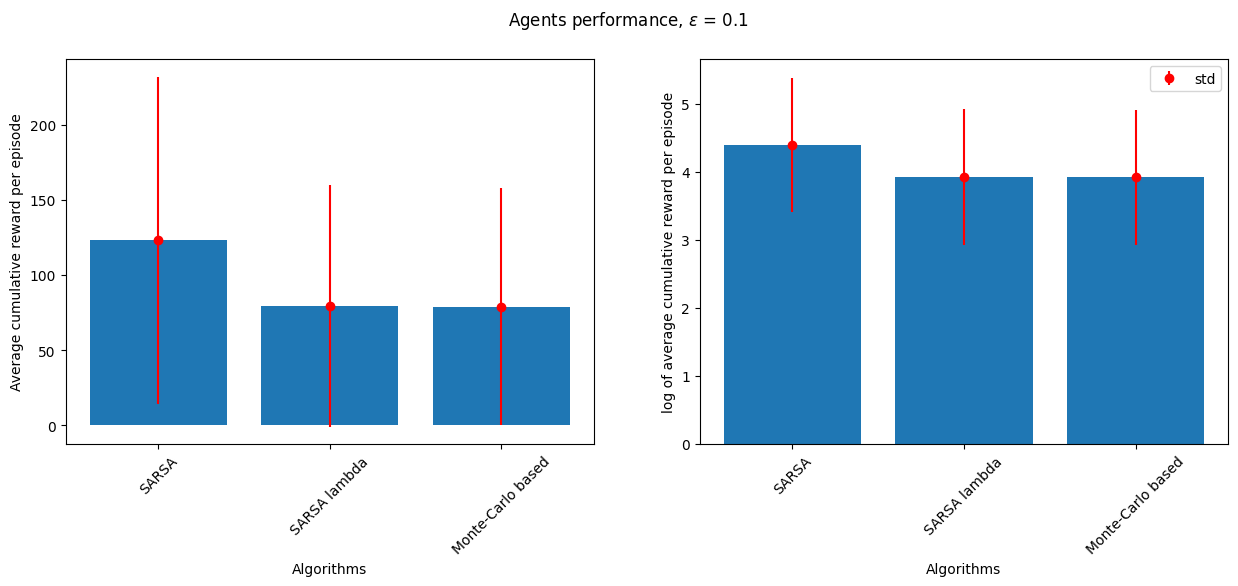

In [77]:
x = ["SARSA", "SARSA lambda", "Monte-Carlo based"]
log_bars = [np.mean(np.log(sarsa_rew)), np.mean(np.log(sarsa_lam_reward)), np.mean(np.log(mc_reward))]
log_err = [np.std(np.log(sarsa_rew)), np.std(np.log(sarsa_lam_reward)), np.std(np.log(mc_reward))]

bars = [np.mean(sarsa_rew), np.mean(sarsa_lam_reward), np.mean(mc_reward)]
err = [np.std(sarsa_rew), np.std(sarsa_lam_reward), np.std(mc_reward)]

print(log_bars, log_err)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].bar(x=x, 
        height=bars)
ax[0].errorbar(x, bars, yerr=err, fmt="o", color="r", label="std")
ax[0].set_xlabel("Algorithms")
ax[0].set_ylabel("Average cumulative reward per episode")
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)

ax[1].bar(x=x, 
        height=log_bars)
ax[1].errorbar(x, log_bars, yerr=log_err, fmt="o", color="r", label="std")
ax[1].set_xlabel("Algorithms")
ax[1].set_ylabel("log of average cumulative reward per episode")
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45)
ax[1].legend()

fig.suptitle(f"Agents performance, $\epsilon$ = {epsilon}")

plt.show()

SARSA $\epsilon$-greedy agent seems to slightly outperforms SARSA($\lambda$) and Monte-Carlo agents. However, due to high values of standars deviation (meaning also that exploraiton was good), wa can't conclude that SARSA is better than the others.

## B. Comparison of the convergence speeds 

Note that we are here measuring the performance of an epsilon-greedy agent. In fact, if we decided to use a greedy agent as we do during the inference, cumulative reward would be infinite and the game never stopped. Unfortunately, I can't wait infinity ;)

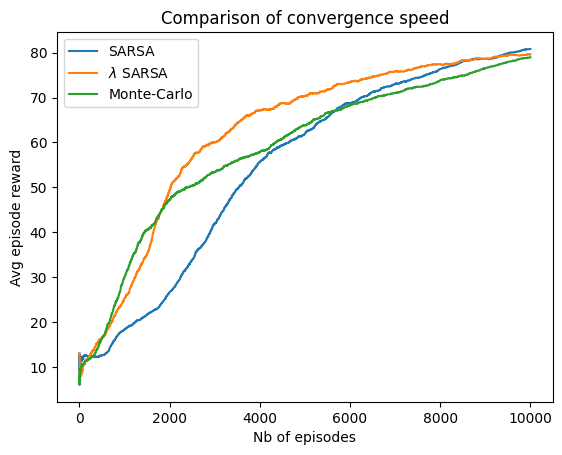

In [40]:
# plot convergence speeds
plt.plot(np.arange(nb_episodes), np.cumsum(sarsa_reward) / (np.arange(nb_episodes)+1), label="SARSA")
plt.plot(np.arange(nb_episodes), np.cumsum(sarsa_lam_reward) / (np.arange(nb_episodes)+1), label="$\lambda$ SARSA")
plt.plot(np.arange(nb_episodes), np.cumsum(mc_reward) / (np.arange(nb_episodes)+1), label="Monte-Carlo")

plt.title("Comparison of convergence speed")
plt.xlabel("Nb of episodes")
plt.ylabel("Avg episode reward")
plt.legend()
plt.show()

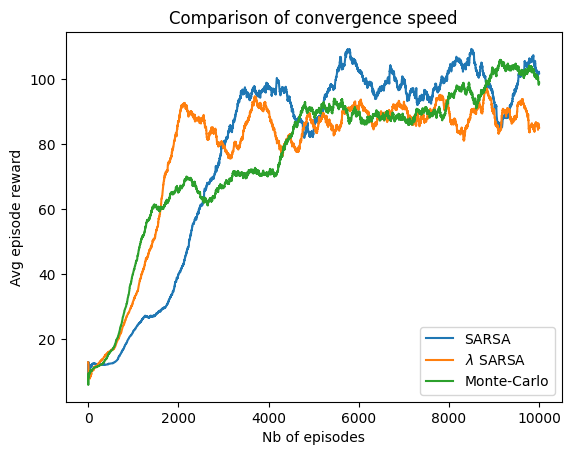

In [64]:
# window for moving average
window = 600
# plot convergence speeds
plt.plot(np.arange(nb_episodes), moving_average(sarsa_reward, window), label="SARSA")
plt.plot(np.arange(nb_episodes), moving_average(sarsa_lam_reward, window), label="$\lambda$ SARSA")
plt.plot(np.arange(nb_episodes), moving_average(mc_reward, window), label="Monte-Carlo")

plt.title("Comparison of convergence speed")
plt.xlabel("Nb of episodes")
plt.ylabel("Avg episode reward")
plt.legend()
plt.show()

As we can see above, monte-carlo increases very fast where SARSA algorithms tends to take more to increase their average episode cumulative reward. However, running the experiment multiple times, we can often observe that SARSA epsilon-greedy agents tends to converge faster to a smaller value. This is a tradeoff to find. SARSA agents can converge faster but not necessarly to the optimal value whereas Monte-Carlo based agent converges to the optimal value but at a lower pace. 

## C. Analysis of state value functions 

Here, we are analysing the vallue function of a greedy agent by taking the argmax over the action of the q_values for each state: 
$$ V(s) = argmax_{a\in A}Q(s, a) $$ 

We are first plotting the function in 3d but for further understanding a 2d representation of the 3d figure is provided. 

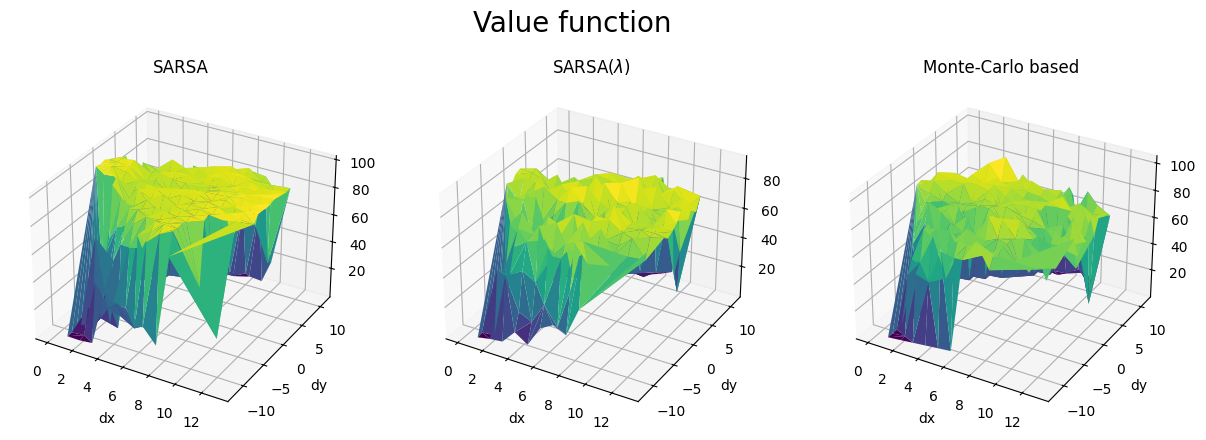

In [42]:
# get x, y and z lists 
x_sarsa, y_sarsa, z_sarsa, _ = plot_value_function(sarsa_agent)
x_sarsa_lam, y_sarsa_lam, z_sarsa_lam, _ = plot_value_function(sarsa_lam_agent)
x_mc, y_mc, z_mc, _ = plot_value_function(mc_agent)

# plot 
fig, ax = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(15, 5))

ax[0].plot_trisurf(x_sarsa, y_sarsa, z_sarsa, cmap='viridis', edgecolor='none')
ax[0].set_title("SARSA")
ax[0].set_xlabel("dx")
ax[0].set_ylabel("dy")

ax[1].plot_trisurf(x_sarsa_lam, y_sarsa_lam, z_sarsa_lam, cmap='viridis', edgecolor='none')
ax[1].set_title("SARSA($\lambda$)")
ax[1].set_xlabel("dx")
ax[1].set_ylabel("dy")

ax[2].plot_trisurf(x_mc, y_mc, z_mc, cmap='viridis', edgecolor='none')
ax[2].set_title("Monte-Carlo based")
ax[2].set_xlabel("dx")
ax[2].set_ylabel("dy")

fig.suptitle("Value function", fontsize=20)

plt.show()

Two conclusions can be drawn from the plot above: 
1) For all algorithms, being close to dy=0 provides higher q values. In fact, behing in front of the open gate gives more chance to not die. 
2) Being to close to the floor is risky. Q_values corresponding to states with small dy (dy $\sim$ -10) have lower q_values as there are more chance to die. However, I will provide an other explanation with the next plot.

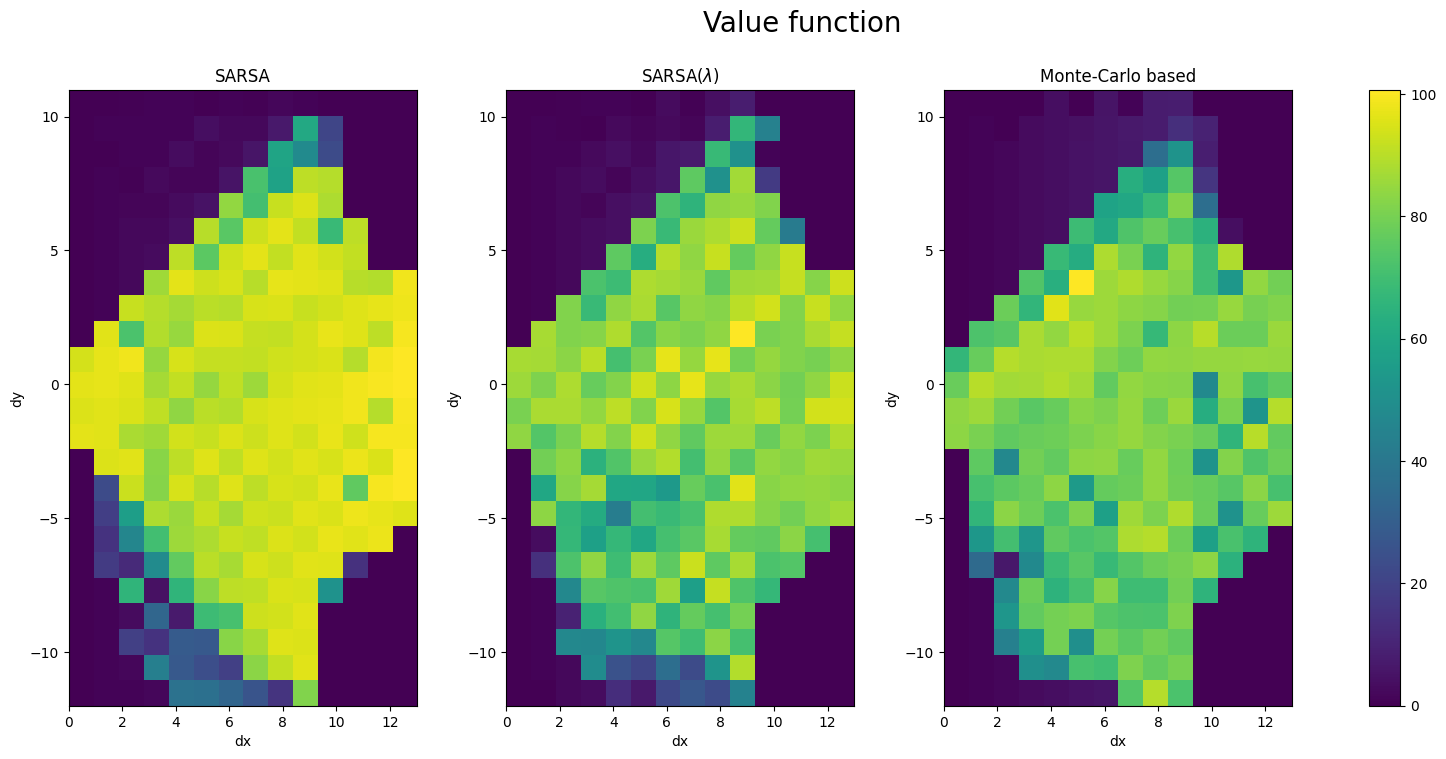

In [43]:
# get 2 images 
im_sarsa = plot_2d_value_function(sarsa_agent)
im_sarsa_lam = plot_2d_value_function(sarsa_lam_agent)
im_mc = plot_2d_value_function(mc_agent)

fig, ax = plt.subplots(1, 3, figsize=(20, 8))

im = ax[0].imshow(im_sarsa, 
                  extent=[0, max(x_sarsa), min(y_sarsa), max(y_sarsa)])
ax[0].set_title("SARSA")
ax[0].set_xlabel("dx")
ax[0].set_ylabel("dy")

ax[1].imshow(im_sarsa_lam, 
             extent=[0, max(x_sarsa_lam), min(y_sarsa_lam), max(y_sarsa_lam)])
ax[1].set_title("SARSA($\lambda$)")
ax[1].set_xlabel("dx")
ax[1].set_ylabel("dy")

ax[2].imshow(im_mc, 
             extent=[0, max(x_mc), min(y_mc), max(y_mc)])
ax[2].set_title("Monte-Carlo based")
ax[2].set_xlabel("dx")
ax[2].set_ylabel("dy")

fig.suptitle("Value function", fontsize=20)
fig.colorbar(im, ax=ax.ravel().tolist())

plt.show()

With these two plots, there is one clear conclusion: the closer you are from the gate, the closer you must be from the center of the gate. This makes sense for two reasons. Firstly, if you are too high and too close, you may not have time to fall in order to go through the open gate. In opposition, being to low is also risky as you may not have time to go through the open space even by flapping. These two points explain the triangular shape of the value function. 

Finally, looking at these plots, there is no real difference in behavior betweeen those three algorithms. 

# 2. Sensitivity to parameters

In this section, I want to observe the sensitivity of algorithms to $\epsilon$, step size, discount. In addition, I also want to measure the snesitivity of SARSA($\lambda$) to $\lambda$ parameter.

In [44]:
# agent parameters
epsilon_values = [0.01, 0.1, 0.25, 0.5, 0.75]
step_size_values = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
discount_values = [1, .9, .8, 0.7, 0.6, .5]
num_actions=2 
lam_values = [1., .9, .8, .7, .6, .5, .4, .3]  # for sarsa lambda agent

In addition, in order to save time, we want to run less episode in this section. 

In [45]:
nb_episodes_2 = 1000

## Sensitivity to epsilon

In [46]:
eps_sarsa_lam = {eps: [] for eps in epsilon_values}
eps_mc = {eps: [] for eps in step_size_values}

for eps in epsilon_values:
    for _ in range(10):

        # sarsa lambda agent
        agent = SarsaLambdaAgent(
                epsilon=eps, 
                step_size=step_size, 
                discount=discount, 
                num_actions=num_actions   
            )
        _, reward = train_sarsa_function(env, agent, num_episode=nb_episodes_2)
        eps_sarsa_lam[eps].append(np.sum(reward) / nb_episodes_2)

        # monte-carlo based agent
        agent = MCAgent(
                epsilon=eps, 
                step_size=step_size, 
                discount=discount, 
                num_actions=num_actions   
            )
        _, reward = train_mc_agent(env, agent, num_episode=nb_episodes_2)
        eps_mc[eps].append(np.sum(reward) / nb_episodes_2)

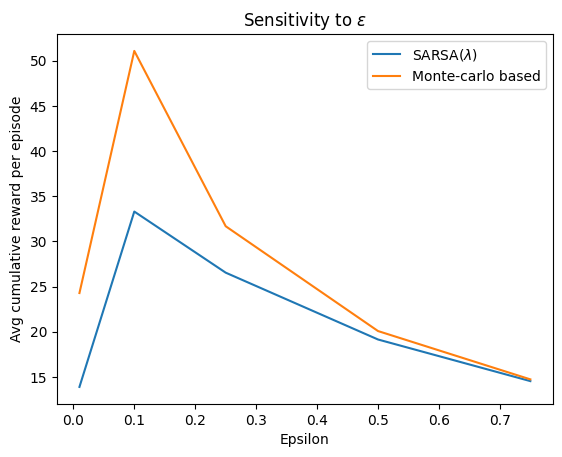

In [47]:
# get average results
eps_sarsa_lam = {key: np.mean(val) for key, val in eps_sarsa_lam.items()}
eps_mc = {key: np.mean(val) for key, val in eps_mc.items()}


plt.plot(eps_sarsa_lam.keys(), eps_sarsa_lam.values(), label="SARSA($\lambda$)")
plt.plot(eps_mc.keys(), eps_mc.values(), label="Monte-carlo based")

plt.xlabel("Epsilon")
plt.ylabel("Avg cumulative reward per episode")
plt.title("Sensitivity to $\epsilon$")
plt.legend()

plt.show()

The $\epsilon$ paramter defines how much the $\epsilon$-greedy agent explores. In particular, small values mean poor exporation leading to poor performance as the agent does not have any chance to explore "good" actions. In opposition, high values mean almost no exploitation (almmost full exploration) leading also to poor result.

## Sensitivity to learning rate (step size)

In [48]:
res_sarsa_lam = {s: [] for s in step_size_values}
res_mc = {s: [] for s in step_size_values}

for s in step_size_values:
    for _ in range(10):

        # sarsa lambda agent
        agent = SarsaLambdaAgent(
                epsilon=epsilon, 
                step_size=s, 
                discount=discount, 
                num_actions=num_actions   
            )
        _, reward = train_sarsa_function(env, agent, num_episode=nb_episodes_2)
        res_sarsa_lam[s].append(np.sum(reward) / nb_episodes_2)

        # monte-carlo based agent
        agent = MCAgent(
                epsilon=epsilon, 
                step_size=s, 
                discount=discount, 
                num_actions=num_actions   
            )
        _, reward = train_mc_agent(env, agent, num_episode=nb_episodes_2)
        res_mc[s].append(np.sum(reward) / nb_episodes_2)

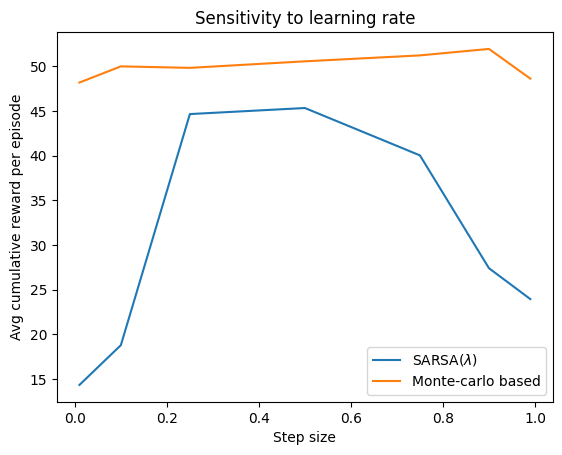

In [49]:
# get average results
res_sarsa_lam = {key: np.mean(val) for key, val in res_sarsa_lam.items()}
res_mc = {key: np.mean(val) for key, val in res_mc.items()}


plt.plot(res_sarsa_lam.keys(), res_sarsa_lam.values(), label="SARSA($\lambda$)")
plt.plot(res_mc.keys(), res_mc.values(), label="Monte-carlo based")

plt.xlabel("Step size")
plt.ylabel("Avg cumulative reward per episode")
plt.title("Sensitivity to learning rate")
plt.legend()

plt.show()

Step size influence the stability of SARSA-based algorithms whereas Monte-Carlo is not sensitivite to it. Step size only affects convergence speed of MC agent.

## Sensitivity to discount factor 

In [50]:
disc_sarsa_lam = {disc: [] for disc in discount_values}
disc_mc = {disc: [] for disc in discount_values}

for disc in discount_values:
    for _ in range(10):

        # sarsa lambda agent
        agent = SarsaLambdaAgent(
                epsilon=epsilon, 
                step_size=step_size, 
                discount=disc, 
                num_actions=num_actions   
            )
        _, reward = train_sarsa_function(env, agent, num_episode=nb_episodes_2)
        disc_sarsa_lam[disc].append(np.sum(reward) / nb_episodes_2)

        # monte-carlo based agent
        agent = MCAgent(
                epsilon=epsilon, 
                step_size=step_size, 
                discount=disc, 
                num_actions=num_actions   
            )
        _, reward = train_mc_agent(env, agent, num_episode=nb_episodes_2)
        disc_mc[disc].append(np.sum(reward) / nb_episodes_2)

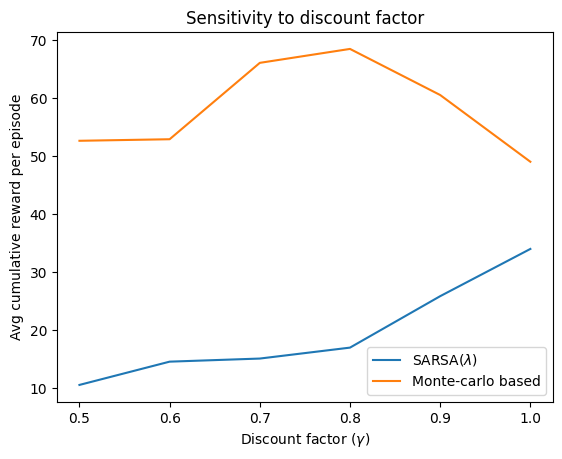

In [51]:
# get average results
disc_sarsa_lam = {key: np.mean(val) for key, val in disc_sarsa_lam.items()}
disc_mc = {key: np.mean(val) for key, val in disc_mc.items()}


plt.plot(disc_sarsa_lam.keys(), disc_sarsa_lam.values(), label="SARSA($\lambda$)")
plt.plot(disc_mc.keys(), disc_mc.values(), label="Monte-carlo based")

plt.xlabel("Discount factor ($\gamma$)")
plt.ylabel("Avg cumulative reward per episode")
plt.title("Sensitivity to discount factor")
plt.legend()

plt.show()

## Sensitivity to $\lambda$ 

In [52]:
lam_sarsa_lam = {lam: [] for lam in lam_values}

for lam in lam_values:
    for _ in range(10):

        # sarsa lambda agent
        agent = SarsaLambdaAgent(
                epsilon=epsilon, 
                step_size=step_size, 
                discount=discount, 
                num_actions=num_actions, 
                lam=lam   
            )
        _, reward = train_sarsa_function(env, agent, num_episode=nb_episodes_2)
        lam_sarsa_lam[lam].append(np.sum(reward) / nb_episodes_2)

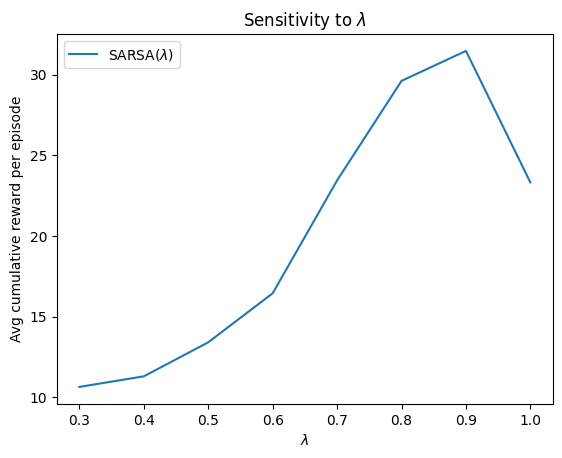

In [53]:
# get average results
lam_sarsa_lam = {key: np.mean(val) for key, val in lam_sarsa_lam.items()}


plt.plot(lam_sarsa_lam.keys(), lam_sarsa_lam.values(), label="SARSA($\lambda$)")

plt.xlabel("$\lambda$")
plt.ylabel("Avg cumulative reward per episode")
plt.title("Sensitivity to $\lambda$")
plt.legend()

plt.show()

# Performance on a different environment

In this section, the goal is to evaluate an agent on a new environment with different settings. We expect the agent to perform worse. However, it may depends on wich parameter has been changed: width, height or pipe gap. 

In [54]:
# parameters for testing
heights = np.arange(7, 26)
widths = np.arange(7, 26)
pipe_gaps = np.arange(2, 10)

## Height sensitivity

In [55]:
h_sarsa_lam = {h: [] for h in heights}
h_sarsa = {h: [] for h in heights}
h_mc = {h: [] for h in heights}

for h in heights:
    new_env = gym.make(
        'TextFlappyBird-v0', 
        height=h, 
        width=width, 
        pipe_gap=pipe_gap
        )
    for i in range(100):
        h_sarsa_lam[h].append(inference(new_env, sarsa_lam_agent, epsilon=epsilon, show=False))
        h_mc[h].append(inference(new_env, mc_agent, epsilon=epsilon, show=False))
        h_sarsa[h].append(inference(new_env, sarsa_agent, epsilon=epsilon, show=False))

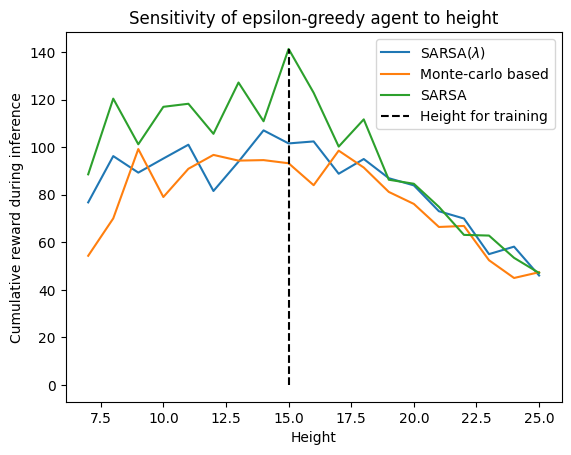

In [56]:
# get average results
h_sarsa_lam = {key: np.mean(val) for key, val in h_sarsa_lam.items()}
h_mc = {key: np.mean(val) for key, val in h_mc.items()}
h_sarsa = {key: np.mean(val) for key, val in h_sarsa.items()}


plt.plot(h_sarsa_lam.keys(), h_sarsa_lam.values(), label="SARSA($\lambda$)")
plt.plot(h_mc.keys(), h_mc.values(), label="Monte-carlo based")
plt.plot(h_sarsa.keys(), h_sarsa.values(), label="SARSA")
plt.vlines(x=height, ymin=0, ymax=max(h_sarsa.values()), 
           color="black", linestyles="--", label="Height for training")

plt.xlabel("Height")
plt.ylabel("Cumulative reward during inference")
plt.title("Sensitivity of epsilon-greedy agent to height")
plt.legend()

plt.show()

Smallest height can lead to lower performance as the agent may think it has margin it has actually not. In opposition, bigger values mean unknown states for the agent and consequently random actions leading to lower performance. 

## Width sensitivity

In [57]:
w_sarsa_lam = {w: [] for w in widths}
w_sarsa = {w: [] for w in widths}
w_mc = {w: [] for w in widths}

for w in widths:
    new_env = gym.make(
        'TextFlappyBird-v0', 
        height=height, 
        width=w, 
        pipe_gap=pipe_gap
        )
    for i in range(100):
        w_sarsa_lam[w].append(inference(new_env, sarsa_lam_agent, epsilon=epsilon, show=False))
        w_mc[w].append(inference(new_env, mc_agent, epsilon=epsilon, show=False))
        w_sarsa[w].append(inference(new_env, sarsa_agent, epsilon=epsilon, show=False))

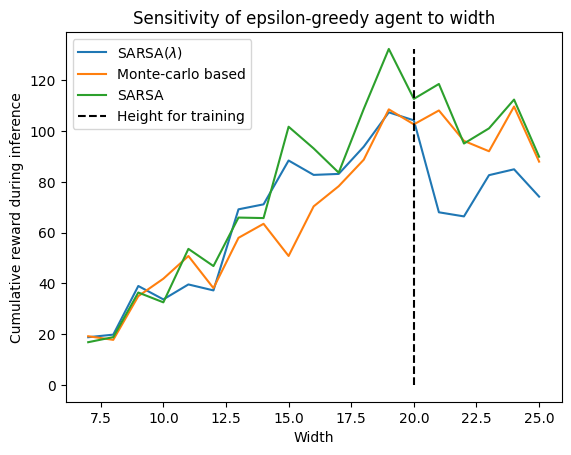

In [58]:
# get average results
w_sarsa_lam = {key: np.mean(val) for key, val in w_sarsa_lam.items()}
w_mc = {key: np.mean(val) for key, val in w_mc.items()}
w_sarsa = {key: np.mean(val) for key, val in w_sarsa.items()}


plt.plot(w_sarsa_lam.keys(), w_sarsa_lam.values(), label="SARSA($\lambda$)")
plt.plot(w_mc.keys(), w_mc.values(), label="Monte-carlo based")
plt.plot(w_sarsa.keys(), w_sarsa.values(), label="SARSA")
plt.vlines(x=width, ymin=0, ymax=max(w_sarsa.values()), 
           color="black", linestyles="--", label="Height for training")

plt.xlabel("Width")
plt.ylabel("Cumulative reward during inference")
plt.title("Sensitivity of epsilon-greedy agent to width")
plt.legend()

plt.show()

Similarly to height, smallest height can lead to lower performance as the agent may think it has margin it has actually not. In opposition, bigger values mean unknown states for the agent and consequently random actions leading to lower performance. 

## Pipe gap sensitivity

In [59]:
p_sarsa_lam = {p: [] for p in pipe_gaps}
p_sarsa = {p: [] for p in pipe_gaps}
p_mc = {p: [] for p in pipe_gaps}

for p in pipe_gaps:
    new_env = gym.make(
        'TextFlappyBird-v0', 
        height=height, 
        width=width, 
        pipe_gap=p
        )
    for i in range(100):
        p_sarsa_lam[p].append(inference(new_env, sarsa_lam_agent, epsilon=epsilon, show=False))
        p_mc[p].append(inference(new_env, mc_agent, epsilon=epsilon, show=False))
        p_sarsa[p].append(inference(new_env, sarsa_agent, epsilon=epsilon, show=False))

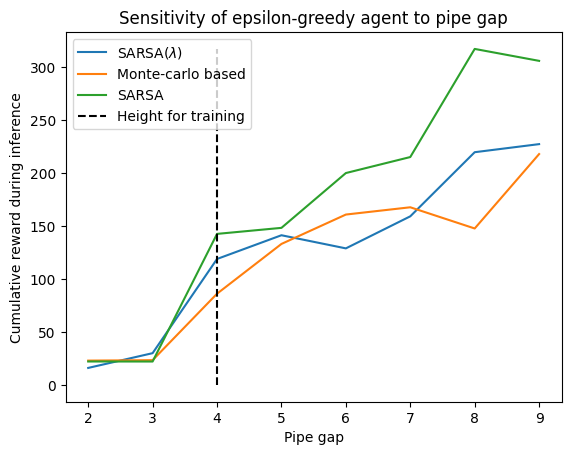

In [60]:
# get average results
p_sarsa_lam = {key: np.mean(val) for key, val in p_sarsa_lam.items()}
p_mc = {key: np.mean(val) for key, val in p_mc.items()}
p_sarsa = {key: np.mean(val) for key, val in p_sarsa.items()}


plt.plot(p_sarsa_lam.keys(), p_sarsa_lam.values(), label="SARSA($\lambda$)")
plt.plot(p_mc.keys(), p_mc.values(), label="Monte-carlo based")
plt.plot(p_sarsa.keys(), p_sarsa.values(), label="SARSA")
plt.vlines(x=pipe_gap, ymin=0, ymax=max(p_sarsa.values()), 
           color="black", linestyles="--", label="Height for training")

plt.xlabel("Pipe gap")
plt.ylabel("Cumulative reward during inference")
plt.title("Sensitivity of epsilon-greedy agent to pipe gap")
plt.legend()

plt.show()

On the one hand, bigger pipe gaps are easier for the agent as it has more margins that it migh think. In a sense the agent is too much cautious. On the other hand, with smaller pipe gaps, the agent is not cautious enough as it is not used to small gaps.